In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from IPython.display import clear_output
import matplotlib.pyplot as plt

import segmentation_models as sm

import tensorflow_addons as tfa
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.2.0


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
def display(display_list, idx=None, only_inference=False, fig_size=15):
    """
    "only_inference" = True designed to create a PNG sample of inferenced image.
    """
    if only_inference:
        plt.figure(figsize=(fig_size,fig_size))
        #a = np.array(display_list)
        #a = a.astype(np.float32) * 255.0
        plt.imshow(display_list)
        plt.axis('off')
        plt.show()

        #cv2.imwrite("EX{}.png".format(idx), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        title = ['Input', 'True', 'Predcited']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            #plt.axis('off')

        plt.show()
    

In [3]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [4]:
def onehot_to_rgb(one_hot):

    channel_0 = np.zeros((480,576,1)) #prediction
    channel_1 = np.zeros((480,576,1))
    channel_2 = np.zeros((480,576,1))
    
    ex = one_hot # ex = H,W,1

    #pushed = tf.expand_dims(ex[:,:,1], -1) + tf.expand_dims(ex[:,:,2], -1)
    #circle = tf.expand_dims(ex[:,:,3], -1)
    #stamped = tf.expand_dims(ex[:,:,2], -1) # stamped = H,W,1
    #bg = tf.expand_dims(ex[:,:,0], -1)
    #hole = tf.expand_dims(ex[:,:,4], -1)

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    
    channel_0[ex==4] = color_dict[4][0]
    channel_1[ex==4] = color_dict[4][1]
    channel_2[ex==4] = color_dict[4][2]

    com = tf.concat([channel_0, channel_1, channel_2], -1)

    display(com, only_inference=True,fig_size=10)

In [5]:
#Compile Options
ACTIVATION = "softmax"
FROM_LOGITS = False 
OPTIMIZER = "RMSprop" 
LR = 0.0001 #0.0001
ENC_FREEZE = False
BACKBONE = 'inceptionv3'

#Fit options
EPOCHS = 100
BATCH = None
NUM_VAL = 5
F_EPOCHS = 20

#Other
IMG_SIZE = (480,576) #Image size must be multiples of 48 to support segmentation models (PSPNET)
STEPS_PER_EPOCH = 30

#CROP_SIZE = [tf.cast((2048/2 - 360), tf.int32), tf.cast((2448/2 - 360), tf.int32),624,672] #x,y,w,h

Get One sample & get unique colors

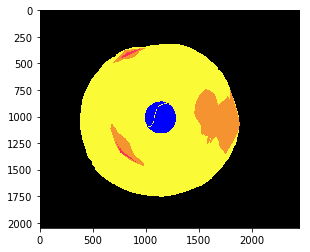

In [8]:
mask = imread('JR_dataset/train/silver_ng/new_gt_mask/높음2__분리막 눌림_은색.png') #2048 x 2448
colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)
plt.imshow(mask)

In [ ]:
color_dict = {i: list(x) for i,x in enumerate(colors)}

color_dict[1] = color_dict[2]
color_dict[2] = color_dict[3]
color_dict[3] = color_dict[4]
color_dict[4] = np.array([0,0,1])

print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int32)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

In [ ]:
a = rgb_to_onehot(mask,color_dict)

bb = tf.expand_dims(np.argmax(a, axis=-1),-1)
bbb = tf.image.resize(bb, IMG_SIZE) #480, 576 960,1152

#bbb = tf.image.crop_to_bounding_box(bb, CROP_SIZE[0], CROP_SIZE[1], CROP_SIZE[2], CROP_SIZE[3])

ccc = tf.image.flip_left_right(bbb)
#angle = np.random.uniform(0,2*np.pi)
#ccc = tfa.image.rotate(bbb, np.pi/2)

display([bbb, ccc]) #hole: 150~300 x 200~400

onehot_to_rgb(bbb)

FDS
[1136 1008  149]
(1136, 1008)


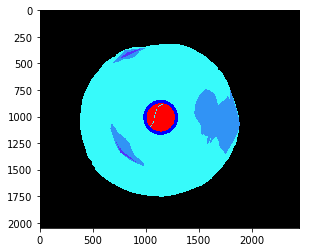

In [55]:
import cv2

mask = cv2.imread('JR_dataset/train/silver_ng/new_gt_mask/높음2__분리막 눌림_은색.png') #2048 x 2448
img_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

rows = img_gray.shape[0]

circles = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                           param1=100, param2=30,
                           minRadius=0, maxRadius=600)
    
    
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        print("FDS")
        print(i) #x, y, r
        center = (i[0], i[1])
        print(center)
        # circle center
        #cv2.circle(mask, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(mask, center, radius, (0, 0, 255), 30)

#mask = tf.image.grayscale_to_rgb(mask)
plt.imshow(mask)
    

In [68]:
point = [1200,1050]
(point[0] - center[0])**2 + (point[1] - center[1])**2 < radius**2
print(mask.shape)

(2048, 2448, 3)


In [185]:
from itertools import product

def points_in_circle(c_x, c_y, radius):
    coors = set()
    for x, y in product(range(int(radius) + 1), repeat= 2):
        if x**2 + y**2 <= radius**2:
            coors.add((x+c_x,y+c_y))
            coors.add((c_x-x,c_y-y))
            coors.add((x+c_x,c_y-y))
            coors.add((c_x-x,y+c_y))
    return coors
            
c_points = points_in_circle(center[0], center[1], radius)

print(c_points)

{(1209, 957), (1193, 1088), (1066, 990), (1137, 1030), (1246, 1100), (1142, 1133), (1105, 892), (1179, 1045), (1248, 917), (1112, 1072), (1075, 932), (1114, 962), (1040, 993), (1095, 901), (1123, 912), (1088, 1021), (1217, 1055), (1113, 1118), (1187, 995), (1118, 917), (1192, 1047), (1136, 969), (1189, 1105), (1088, 1112), (1023, 1039), (1085, 1024), (1196, 883), (1074, 1063), (1145, 877), (1235, 1007), (1071, 1117), (998, 1047), (1060, 1046), (1041, 1114), (1046, 1089), (1191, 936), (1027, 923), (1184, 986), (1041, 967), (1239, 956), (1165, 1081), (1050, 959), (1174, 969), (1089, 979), (1047, 1077), (1031, 976), (1273, 1026), (1098, 899), (1259, 1075), (1222, 1093), (1137, 1007), (1079, 964), (1211, 1120), (1144, 1085), (1197, 1101), (1234, 1091), (1141, 1083), (1146, 919), (1130, 1136), (1162, 912), (1093, 908), (1127, 1016), (1201, 894), (1116, 1059), (1012, 1089), (1016, 1067), (1171, 930), (1028, 1017), (1210, 900), (1141, 912), (1235, 1067), (1150, 966), (1076, 1005), (1224, 1092

In [186]:
mask = cv2.imread('JR_dataset/train/silver_ng/new_gt_mask/높음2__분리막 눌림_은색.png') #2048 x 2448
print(len(c_points))
[list(mask[y][x]) for x,y in c_points]

69729


[[255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [55, 250, 250],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [55, 250, 250],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [55, 250, 250],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0],
 [255, 0, 0

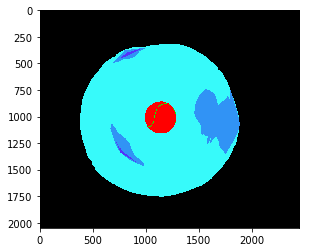

In [192]:
mask = cv2.imread('JR_dataset/train/silver_ng/new_gt_mask/높음2__분리막 눌림_은색.png') #2048 x 2448

aa = [(x,y) for x,y in c_points if list(mask[y][x]) == [55,250,250]] 

for (x,y) in aa:
    mask[y][x] = [0,255,0]
    
plt.imshow(mask)

In [164]:
import glob
import cv2
train_x = []
train_y = []

for img in glob.glob("JR_dataset/train/*/*.bmp"):

    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    bbb = tf.image.resize(n, IMG_SIZE)
    
    bbb = tf.image.rgb_to_grayscale(bbb)

    flipped_img = tf.image.flip_up_down(bbb)
    
    train_x.append(bbb)
    train_x.append(flipped_img)

    #GET FILE NAME
    dir = "/".join(img.split("/")[:-1]) + "/new_gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name+".png")
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbbb = tf.image.resize(bb, IMG_SIZE)

    flipped_mask = tf.image.flip_up_down(bbbb)

    train_y.append(bbbb)
    train_y.append(flipped_mask)
    
train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)

print(train_x.shape, np.max(train_x))
print(train_y.shape, np.max(train_y))

NameError: name 'rgb_to_onehot' is not defined

In [ ]:
display([train_x[13], train_y[13]])
onehot_to_rgb(train_y[13])

In [ ]:
sample_image = train_x[13]
sample_mask = train_y[13] 

찍힘 class에 가장 높은 weight, "눌림" class에 그 다음 높은 weight 적용

In [ ]:
# 0 shows background, 1 shows "pushed", 2shows "Stamped", 3shows inner circle, 4 shows hole

sample_weights = np.zeros(train_y.shape)
# print(sample_weights.shape) #92 480 576 1

bg_count = (np.array(train_y)==0).sum()
circle_count = (np.array(train_y)==3).sum()
push_count = (np.array(train_y)==1).sum()
stamp_count = (np.array(train_y)==2).sum()
hole_count = (np.array(train_y)==4).sum()

denom = bg_count+circle_count+push_count+stamp_count+hole_count

CLASS_WEIGHT = [(denom/bg_count).round(), (denom/push_count).round(), (denom/stamp_count).round(), 
                (1000 * denom/circle_count).round(), (denom/hole_count).round()]

print(CLASS_WEIGHT)

# your own weight corresponding here:
sample_weights[train_y==0] = CLASS_WEIGHT[0]                                                                                                             
sample_weights[train_y==1] = CLASS_WEIGHT[1]                                                                                                            
sample_weights[train_y==2] = CLASS_WEIGHT[2]                                                                                                             
sample_weights[train_y==3] = CLASS_WEIGHT[3]     
sample_weights[train_y==4] = CLASS_WEIGHT[4]  


In [ ]:
print(train_x.shape, train_y.shape)

Define Backbone model as well as segmentation model

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR) #default 0.001


model = sm.PSPNet(BACKBONE, input_shape = IMG_SIZE + (1,), classes=5, encoder_weights=None, 
                  activation=ACTIVATION, encoder_freeze = ENC_FREEZE)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS),  #False for multiclass. True for binary class
    metrics=['accuracy'], 
)

In [ ]:
show_predictions()

In [ ]:
import gc
import os
import datetime

gc.collect()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('{}에포크 이후의 예측 예시'.format(epoch+1))
    print ('Current Accuracy: {}'.format(logs['accuracy']))
    print ('Validation Accuracy: {}'.format(logs['val_accuracy']))
    gc.collect()
    

In [ ]:
model_history = model.fit(x= train_x[NUM_VAL:],
                          y= train_y[NUM_VAL:], 
                          batch_size = BATCH,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          epochs=EPOCHS,
                          validation_data = (train_x[:NUM_VAL], train_y[:NUM_VAL], sample_weights[:NUM_VAL]),
                          callbacks=[DisplayCallback()],
                          sample_weight = sample_weights[NUM_VAL:],)                                

In [ ]:
test_x = []
test_y = []

for img in glob.glob("JR_dataset/test/*.bmp"):

    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE)
    
    n = tf.image.rgb_to_grayscale(n)
    
    test_x.append(n)
    
    dir = "/".join(img.split("/")[:-1]) + "/new_gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name+".png")
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, IMG_SIZE)
    
    test_y.append(bbb)

test_x = tf.convert_to_tensor(test_x)
test_y = tf.convert_to_tensor(test_y)

print(test_x.shape)
print(test_y.shape)

In [ ]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=4)

Finetuning with smaller learning rate (make whole model trainable)



In [ ]:
model.trainable = True

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR/10) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR/10) #default 0.001

model.compile(
    optimizer = opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'],
)

In [ ]:
finetune_history = model.fit(x= train_x[NUM_VAL:],
                          y= train_y[NUM_VAL:], 
                          batch_size = BATCH,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          epochs=F_EPOCHS,
                          validation_data = (train_x[:NUM_VAL], train_y[:NUM_VAL], sample_weights[:NUM_VAL]),
                          callbacks=[DisplayCallback()],
                          sample_weight = sample_weights[NUM_VAL:])    

In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

WITH FINETUNING

In [ ]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=4)

In [ ]:
pred_mask = model.predict(test_x, batch_size=1)
aaa = create_mask(pred_mask, num=3)
dd = tf.one_hot(aaa, 5)
print(dd.shape)

In [ ]:
display([test_y[3], dd[:,:,:,4], dd[:,:,:,1]]) 
# 0 shows background, 1 shows "pushed", 2shows "Stamped", 3shows inner circle

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS-3)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 60])
plt.legend()
plt.show()

In [ ]:
loss = finetune_history.history['loss']
val_loss = finetune_history.history['val_loss']

epochs = range(F_EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 60])
plt.legend()
plt.show()

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS-3)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95,1])
plt.legend()
plt.show()

In [ ]:
acc = finetune_history.history['accuracy']
val_acc = finetune_history.history['val_accuracy']

epochs = range(F_EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.98,1])
plt.legend()
plt.show()

In [ ]:
print("Training accuracy at the last epoch is:", np.round(model_history.history['accuracy'][-1],3))

In [ ]:
print("Training accuracy (after finetuning) at the last epoch is:", np.round(finetune_history.history['accuracy'][-1],3))

Saving Model for use in Inference

In [ ]:
model.save('saved_model_1014_combined_{}_{}_{}_ENCFRZ_{}_onechannel'.format(OPTIMIZER, EPOCHS, LR, ENC_FREEZE))